In [2]:
import numpy as np
import scipy.linalg as la
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import floyd_warshall
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components

## Assignment 1



## Solution
1. Formular of PCA and solution of PCA
   1. the importance of eigenvalue and eigenvectors and they should be sorted(find the largest eigenvalue)
   2. conclude the corresponding variables in assignment 1
      1. C is the data center; D is eigenvalue from largest to smallest, U is eigenvectors corresponding to the eigenvalues; Z is the projection(reconstruct of the data); Y is denoised reconstruction
2. projection(reconstruct the data)
   1. formular on the guide book
3. noise influence
   1. need find more information

In [92]:
def pca(X, m):
    C = np.mean(X, axis=0)
    X_centered = X - C
    Cov = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(Cov)
    idx = np.argsort(eigenvalues)[::-1] # sorted is from the smallest to the largest
    sorted_eigenvalues = eigenvalues[idx]
    sorted_eigenvectors = eigenvectors[:, idx]
    D = sorted_eigenvalues[:m]
    U = sorted_eigenvectors[:, :m] # choose the first m eigenvectors
    Z = np.dot(X_centered, U)
    Y = np.dot(Z, U.T) + C
    return C, D, U, Z, Y

## Assignment 2

1. use the distance_matrix to get the D
2. [adjaceny matrix](https://en.wikipedia.org/wiki/Adjacency_matrix)

In [6]:
def gamma_index(X, k):
    n = X.shape[0]  # Number of data points
    D = distance_matrix(X, X)  # Compute the distance matrix
    
    # Initialize the γ-index array
    y = np.zeros(n)
    
    # Iterate over each data point
    for i in range(n):
        # Find the indices of the k-nearest neighbors (including the point itself)
        neighbor_ids = np.argsort(D[i])[:k+1]  # Get the k+1 smallest distances (including itself)
        
        # Retrieve the original points for the k-nearest neighbors
        neighbors = X[neighbor_ids]
        
        # Project the neighbors: This step involves PCA or any dimensionality reduction method
        # Here we are assuming a simple mean subtraction is the 'projection'
        projected_neighbors = neighbors - neighbors.mean(axis=0)
        
        # Compute the mean Euclidean distance from the point to its projected neighbors
        y[i] = np.mean(np.linalg.norm(X[i] - projected_neighbors, axis=1))
    
    return y

In [7]:
def gammaidx(X, k):
    D = distance_matrix(X, X)
    indices = np.argsort(D, axis=1)[:, 1:k+1]
    A = np.zeros_like(D)
    row_indices = np.arange(D.shape[0])[:, None]
    A[row_indices, indices] = 1
    Dg = floyd_warshall(A, directed=False)
    Dg_squared = np.square(Dg)
    A = -0.5 * Dg_squared
    n = X.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    M = H @ A @ H
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    sorted_indices = np.argsort(-eigenvalues)
    positive_indices = eigenvalues > 0
    V = eigenvectors[:, sorted_indices][:, positive_indices]
    eigval = eigenvalues[sorted_indices][positive_indices]
    Z = (V * np.sqrt(eigval)).T
    return (X - Z).sum()/k

## Assignment 3

### Model evaluation
1. definition of TP, FP, TN, FN
2. definition and relation of tpr, fpr, auc, acc, roc

In [9]:
def auc(y_true, y_pred, plot = False):
    TP = np.sum((y_pred == 1) & (y_true == 1))
    FP = np.sum((y_pred == 1) & (y_true == -1))
    TN = np.sum((y_pred == -1) & (y_true == -1))
    FN = np.sum((y_pred == -1) & (y_true == 1))
    tpr = TP / (TP + FN) if TP + FP != 0 else 0
    fpr = FP / (FP + TN) if FP + TN != 0 else 0
    auc = np.trapz(tpr, fpr)
    if plot == True:
        plt.figure(figsize = (8,6))
        plt.plot(fpr, tpr, label = "ROC Curve")
        plt.xlabel("False positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend()
        plt.show()
    else:
        return auc

## Assignment 4

How to check the resulting graph

In [3]:
def lle(X, m, n_rule, param, tol=1e-2):
    n = X.shape[0]
    D = distance_matrix(X, X)
    if n_rule == 'knn':
        neighbors = np.argsort(D, axis=1)[:, 1:param+1]
    elif n_rule == 'eps-ball':
        neighbors = [np.where(D[i] <= param)[0] for i in range(n)]
    else:
        raise ValueError("Invalid neighborhood rule specified.")

    w_initial = np.zeros((n, n))
    for i in range(n):
        k_i = neighbors[i]
        Z = X[k_i] - X[i]
        C = np.dot(Z, Z.T)
        w = np.linalg.solve(C + tol * np.eye(len(k_i)), np.ones(len(k_i)))
        w_initial[i, k_i] = w / np.sum(w)

    M = np.eye(n) - w_initial
    M = np.dot(M.T, M)
    eigenvalues, eigenvectors = np.linalg.eigh(M)
    idx = np.argsort(eigenvalues)[1:m+1]  # ignore the first smallest zero eigenvalue
    return eigenvectors[:, idx]

## Assignment 5

In [16]:
import numpy as np
import pylab as pl
import random
from scipy.io import loadmat

In [20]:
data = loadmat('/Users/yanqingluo/Desktop/LabML/problem_set1/data/usps.mat')
for key in data.keys():
    print(key)

__header__
__version__
__globals__
data_labels
data_patterns


In [86]:
X = data['data_patterns']
X =  np.array(X)
y = data['data_labels']
print(len(X), len(y))

256 10


In [54]:
## Calculate PCA for this data
idx,Z, Y = pca(X, 2)

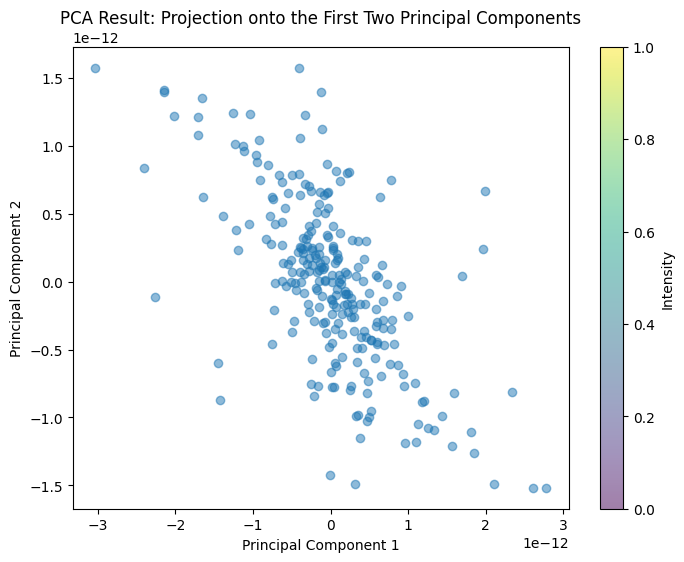

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5)
plt.title('PCA Result: Projection onto the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Intensity')
plt.show()

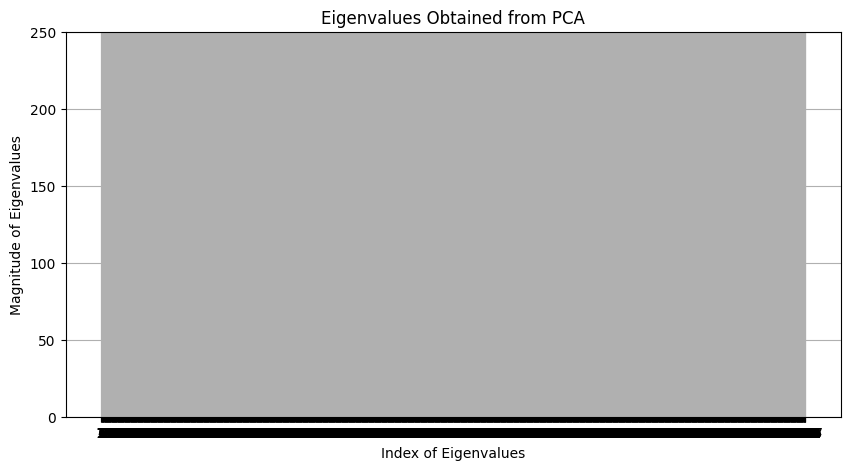

2007


In [67]:
d = X.shape[1]
eigs, eigv, Z_all, Y_all = pca(X, d)

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(eigs) + 1), eigs, color='royalblue')
plt.xlabel('Index of Eigenvalues')
plt.ylabel('Magnitude of Eigenvalues')
plt.title('Eigenvalues Obtained from PCA')
plt.xticks(range(1, len(eigs) + 1))  # Add tick marks for clarity
plt.grid(True)
plt.show()
print(len(eigs))

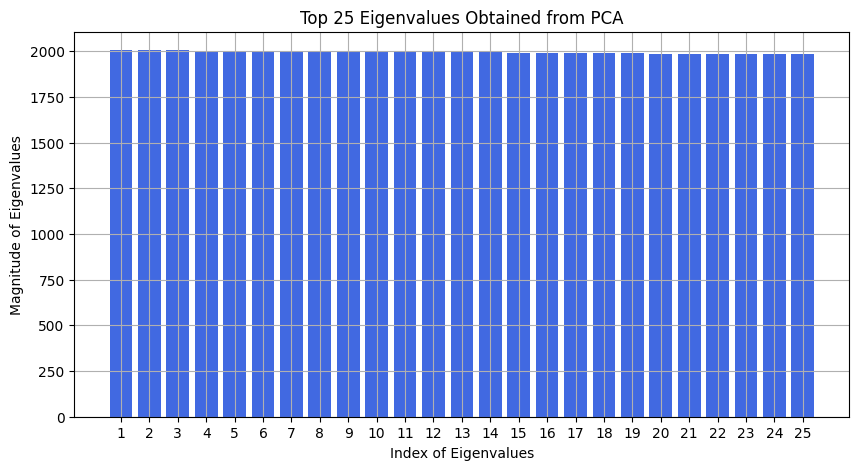

In [65]:
largest_25 = eigs[:25]
plt.figure(figsize=(10, 5))
plt.bar(range(1, 26), largest_25, color='royalblue')  # Correct range to match the number of eigenvalues
plt.xlabel('Index of Eigenvalues')
plt.ylabel('Magnitude of Eigenvalues')
plt.title('Top 25 Eigenvalues Obtained from PCA')
plt.xticks(range(1, 26))  # Ensure ticks match the number of eigenvalues
plt.grid(True)
plt.show()

(2007, 5)


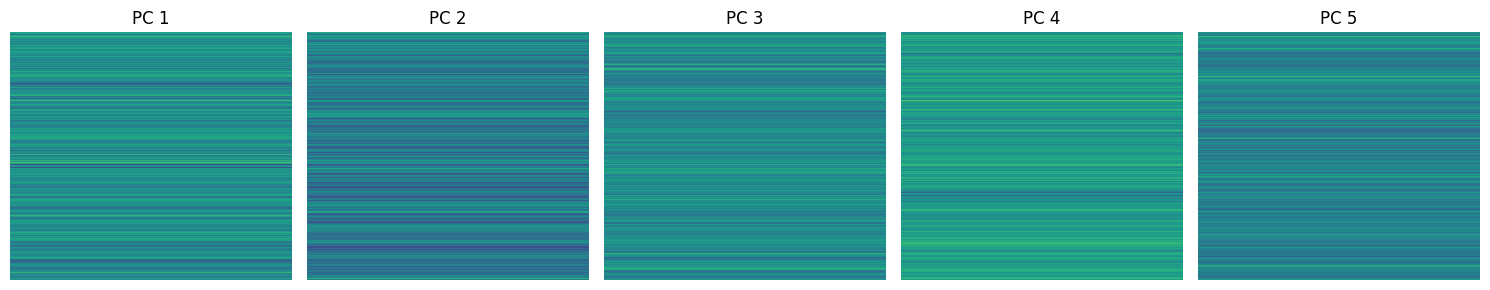

In [90]:
sorted_eigenvalues, sorted_eigenvectors,U, Z, Y = pca(X, 5)
print(U.shape)
image_shape = (2007, 1)  # Adjust this based on your actual data structure

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    # Reshape the i-th principal component to 28x28 and plot it
    pc_image = U[:, i].reshape(image_shape)
    ax.imshow(pc_image, cmap='viridis', aspect='auto')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Assignment 8.
Study the influence of noise on LLE, using the example of the flatroll data set.

## Task 1.

In [6]:
froll_data = np.load('C:/Users/Tue/Lab-ML/problem_set1/data/flatroll_data.npz')
for key in froll_data.keys():
    print(key)

X = froll_data.f.Xflat
Y = froll_data.f.true_embedding[0]
# len(Y)
len(X[0])
X.shape

Xflat
true_embedding


(2, 1000)

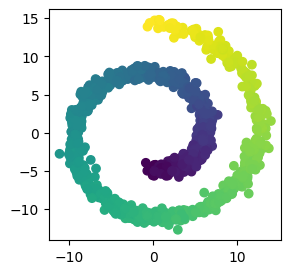

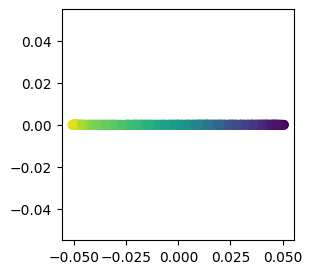

In [9]:
plt.figure(figsize=(3,3))
plt.scatter(X.T[:,0],X.T[:,1],c=Y)
plt.show()

X_lle =lle(X.T, 1, 'knn', 15, tol=1e-2)
plt.figure(figsize=(3,3))
plt.scatter(X_lle, np.zeros([1000,1]), c = Y)
plt.show()

## Task.2-4

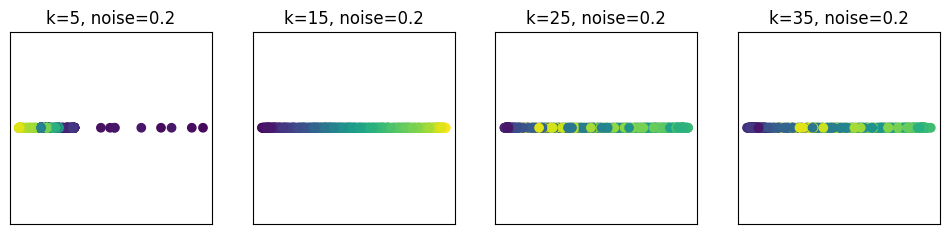

In [10]:
f = plt.figure(figsize=(12,2.5))
for t,(k,noi) in enumerate([(5,0.2),(15,0.2),(25,0.2),(35,0.2)]):
    noise = np.random.normal(0, noi, len(Y)) #  add low noise: μ = 0, σ = 0.2, size = length of Y.
    X_n = X + noise  # variance = 0.2
    # lle = LocallyLinearEmbedding(n_components=1, n_neighbors=k) 
    X_lle = lle(X_n.T, 1, 'knn', k, tol=1e-2)
    ax = f.add_subplot(1,4,t+1)
    ax.set_title('k=%d, noise=%.1f'%(k,noi))
    ax.set_xticks([])
    ax.set_yticks([]) 
    ax.scatter(X_lle,np.zeros(len(Y)),c=Y)

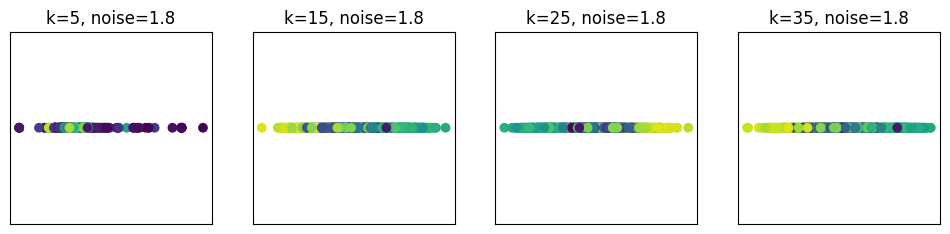

In [11]:
f = plt.figure(figsize=(12,2.5))
for t,(k,noi) in enumerate([(5, 1.8),(15,1.8),(25, 1.8),(35, 1.8)]):
    noise = np.random.normal(0, noi, len(Y)) # add high noise: μ = 0, σ = 0.2, size = length of Y.
    X_n = X + noise  # variance = 0.2
    # lle = LocallyLinearEmbedding(n_components=1, n_neighbors=k) 
    X_lle = lle(X_n.T, 1, 'knn', k, tol=1e-2)
    ax = f.add_subplot(1,4,t+1)
    ax.set_title('k=%d, noise=%.1f'%(k,noi))
    ax.set_xticks([])
    ax.set_yticks([]) 
    ax.scatter(X_lle,np.zeros(len(Y)),c=Y)